In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skmultilearn.model_selection import iterative_train_test_split

2022-06-27 13:56:51.539853: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
tf.__version__

'2.4.1'

# Data Load

In [4]:
df = pd.read_csv('/home/lab38/Multi_proj_6/data/lettu_smallsizeimg_with_pest.csv')
df.head()

,image,grow,disease,disease-grow,area,points,original
0,/home/lab38/상추/358.jpg,1,12,12-1,NaN,NaN,NaN
1,/home/lab38/상추/235.jpg,1,12,12-1,NaN,NaN,NaN
2,/home/lab38/상추/39.jpg,0,12,12-0,NaN,NaN,NaN
3,/home/lab38/상추/345.jpg,1,12,12-1,NaN,NaN,NaN
4,/home/lab38/상추/97.jpg,1,12,12-1,NaN,NaN,NaN


In [5]:
# label encoding
disease_encoder = LabelEncoder()
disease_encoder.fit(df['disease'])
df['disease'] = disease_encoder.transform(df['disease'])
print(df['disease'].unique())

grow_encoder = LabelEncoder()
grow_encoder.fit(df['grow'])
df['grow'] = grow_encoder.transform(df['grow'])
print(df['grow'].unique())

[3 0 1 2]
[1 0]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['image'],
                                                   df['disease-grow'],
                                                   stratify=df['disease-grow'],
                                                   test_size=0.2)

In [7]:
train_df = df[df['image'].isin(X_train)]
test_df = df[df['image'].isin(X_test)]

In [8]:
train_gen = ImageDataGenerator(rescale=1./255,
                            rotation_range=20, # 최대 20도까지 회전
                            width_shift_range=0.1, # 최대 x 범위안에서 좌우/상하 이동
                            height_shift_range=0.1,
                            zoom_range=0.2, # 확대 축소 비율,
                            horizontal_flip=True, # 좌우반전
                            vertical_flip=True, # 상하반전
                            fill_mode='nearest')
valid_gen = ImageDataGenerator(rescale= 1. /255.)

# Model Top layer 학습

In [10]:
IMAGE_SIZE=320
BATCH_SIZE = 50
EPOCHS = 1000
DROPOUT = 0.2
LEARNING_RATE = 1e-3
ACTIVATION = 'relu'
OPTIMIZER = 'rmsprop'
DENSE = 32

train_generator = train_gen.flow_from_dataframe(train_df, 
                                           x_col='image',
                                           y_col=['disease', 'grow'],
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                           class_mode='multi_output',
                                           batch_size=BATCH_SIZE)
valid_generator = valid_gen.flow_from_dataframe(test_df,
                                           x_col='image',
                                           y_col=['disease','grow'],
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                           class_mode='multi_output',
                                           batch_size=BATCH_SIZE)

MODEL_IMAGE_SIZE = 299
base_model = inception_resnet_v2.InceptionResNetV2(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
)
base_model.trainable = False

# resizing model
input_data = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
resizing = Model(inputs=input_data, outputs=x, name='resize')

# model
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resizing(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(DROPOUT)(x)
backbone_out = layers.Dense(DENSE, activation=ACTIVATION)(x)

disease_outputs = layers.Dense(df['disease'].nunique(), activation='softmax',
                        name = 'diease_outputs')(backbone_out)
grow_outputs = layers.Dense(1, activation='sigmoid',
                    name = 'grow_outputs')(backbone_out)

model = Model(inputs=inputs, 
              outputs=[disease_outputs, grow_outputs],
              name='strawberry')  

es = EarlyStopping(monitor='loss',
                   mode='auto',
                  patience=5,
                  verbose=1)

ckpt_path = './graph_toplayer.ckpt'
checkpointer = ModelCheckpoint(filepath=ckpt_path,
                              monitor='val_loss',
                              save_weights_only = True,
                              save_best_only= True,
                              verbose=1)

optimizer = RMSprop(learning_rate=LEARNING_RATE)

es = EarlyStopping(monitor='loss',
                   mode='auto',
                  patience=5,
                  verbose=1)

ckpt_path = './toplayer_lettuce.ckpt'
checkpointer = ModelCheckpoint(filepath=ckpt_path,
                              monitor='val_loss',
                              save_weights_only = True,
                              save_best_only= True,
                              verbose=1)

model.compile(loss={
              'diease_outputs' : 'sparse_categorical_crossentropy',
              'grow_outputs' : 'binary_crossentropy'
              },
              optimizer=optimizer,
              metrics=['accuracy'])    

history = model.fit(train_generator,
                      validation_data=valid_generator,
                      verbose=1,
                      epochs=EPOCHS,
                      callbacks=[es, checkpointer],
                      steps_per_epoch=len(train_df)//BATCH_SIZE)

Found 4738 validated image filenames.
Found 1185 validated image filenames.


2022-06-27 13:57:50.240070: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-27 13:57:50.256938: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/1000


2022-06-27 13:57:58.598920: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-27 13:57:59.645422: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


94/94 [==============================] - 129s 1s/step - loss: 1.1925 - diease_outputs_loss: 0.9088 - grow_outputs_loss: 0.2838 - diease_outputs_accuracy: 0.6263 - grow_outputs_accuracy: 0.8829 - val_loss: 0.5584 - val_diease_outputs_loss: 0.4410 - val_grow_outputs_loss: 0.1174 - val_diease_outputs_accuracy: 0.8422 - val_grow_outputs_accuracy: 0.9654

Epoch 00001: val_loss improved from inf to 0.55843, saving model to ./toplayer_lettuce.ckpt
Epoch 2/1000
94/94 [==============================] - 114s 1s/step - loss: 0.6129 - diease_outputs_loss: 0.4496 - grow_outputs_loss: 0.1633 - diease_outputs_accuracy: 0.8290 - grow_outputs_accuracy: 0.9427 - val_loss: 0.4463 - val_diease_outputs_loss: 0.3515 - val_grow_outputs_loss: 0.0948 - val_diease_outputs_accuracy: 0.8658 - val_grow_outputs_accuracy: 0.9679

Epoch 00002: val_loss improved from 0.55843 to 0.44629, saving model to ./toplayer_lettuce.ckpt
Epoch 3/1000
94/94 [==============================] - 114s 1s/step - loss: 0.5043 - diease_ou


Epoch 00019: val_loss improved from 0.25871 to 0.25838, saving model to ./toplayer_lettuce.ckpt
Epoch 20/1000
94/94 [==============================] - 113s 1s/step - loss: 0.2956 - diease_outputs_loss: 0.2162 - grow_outputs_loss: 0.0794 - diease_outputs_accuracy: 0.9214 - grow_outputs_accuracy: 0.9752 - val_loss: 0.2811 - val_diease_outputs_loss: 0.2255 - val_grow_outputs_loss: 0.0557 - val_diease_outputs_accuracy: 0.9207 - val_grow_outputs_accuracy: 0.9797

Epoch 00020: val_loss did not improve from 0.25838
Epoch 21/1000
94/94 [==============================] - 113s 1s/step - loss: 0.2991 - diease_outputs_loss: 0.2249 - grow_outputs_loss: 0.0743 - diease_outputs_accuracy: 0.9185 - grow_outputs_accuracy: 0.9750 - val_loss: 0.2614 - val_diease_outputs_loss: 0.2112 - val_grow_outputs_loss: 0.0503 - val_diease_outputs_accuracy: 0.9173 - val_grow_outputs_accuracy: 0.9873

Epoch 00021: val_loss did not improve from 0.25838
Epoch 22/1000
94/94 [==============================] - 114s 1s/step


Epoch 00038: val_loss did not improve from 0.21820
Epoch 39/1000
94/94 [==============================] - 114s 1s/step - loss: 0.2604 - diease_outputs_loss: 0.1909 - grow_outputs_loss: 0.0695 - diease_outputs_accuracy: 0.9337 - grow_outputs_accuracy: 0.9749 - val_loss: 0.2393 - val_diease_outputs_loss: 0.1874 - val_grow_outputs_loss: 0.0519 - val_diease_outputs_accuracy: 0.9291 - val_grow_outputs_accuracy: 0.9823

Epoch 00039: val_loss did not improve from 0.21820
Epoch 40/1000
94/94 [==============================] - 114s 1s/step - loss: 0.2473 - diease_outputs_loss: 0.1806 - grow_outputs_loss: 0.0667 - diease_outputs_accuracy: 0.9294 - grow_outputs_accuracy: 0.9775 - val_loss: 0.2170 - val_diease_outputs_loss: 0.1752 - val_grow_outputs_loss: 0.0418 - val_diease_outputs_accuracy: 0.9392 - val_grow_outputs_accuracy: 0.9848

Epoch 00040: val_loss improved from 0.21820 to 0.21703, saving model to ./toplayer_lettuce.ckpt
Epoch 41/1000
94/94 [==============================] - 114s 1s/step

In [11]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
grow_acc = history.history['grow_outputs_accuracy']
val_grow_acc = history.history['val_grow_outputs_accuracy']
disease_acc = history.history['diease_outputs_accuracy']
val_disease_acc = history.history['val_diease_outputs_accuracy']

In [12]:
log = pd.DataFrame(history.history)
log.to_csv('./top layer history.csv', index=False)

# Fine Tuning

In [13]:
start = len(history.history['loss'])
IMAGE_SIZE = 320
FREEZE_RATE = 0.9

In [14]:
############### 동결 해제 ###################
base_model.trainable=True
fine_tune_at = int(len(base_model.layers) * FREEZE_RATE)
for layer in base_model.layers[:fine_tune_at] :
    layer.trainable = False  
    
    
model.compile(optimizer=Adam(LEARNING_RATE/10),  ## compile
              loss={
                  'diease_outputs' : 'sparse_categorical_crossentropy',
                  'grow_outputs' : 'binary_crossentropy'
                },
                metrics=['accuracy'])


ckpt_path_ = './graph_finetune.ckpt'
checkpointer= ModelCheckpoint(filepath=ckpt_path_,
                          monitor='val_loss',
                          save_weights_only = True,
                          save_best_only= True,
                          verbose=1)
## finetuning
history_fine = model.fit(train_generator,
                          validation_data=valid_generator,
                          verbose=1,
                          epochs=EPOCHS,
                          initial_epoch = start,
                          callbacks=[es, checkpointer],  # model save at wandb
                          steps_per_epoch=len(train_df)//BATCH_SIZE)

Epoch 48/1000
94/94 [==============================] - 127s 1s/step - loss: 0.2775 - diease_outputs_loss: 0.2245 - grow_outputs_loss: 0.0531 - diease_outputs_accuracy: 0.9165 - grow_outputs_accuracy: 0.9818 - val_loss: 0.1646 - val_diease_outputs_loss: 0.1294 - val_grow_outputs_loss: 0.0351 - val_diease_outputs_accuracy: 0.9561 - val_grow_outputs_accuracy: 0.9848

Epoch 00048: val_loss improved from inf to 0.16455, saving model to ./graph_finetune.ckpt
Epoch 49/1000
94/94 [==============================] - 115s 1s/step - loss: 0.1777 - diease_outputs_loss: 0.1367 - grow_outputs_loss: 0.0410 - diease_outputs_accuracy: 0.9537 - grow_outputs_accuracy: 0.9874 - val_loss: 0.1495 - val_diease_outputs_loss: 0.1156 - val_grow_outputs_loss: 0.0339 - val_diease_outputs_accuracy: 0.9527 - val_grow_outputs_accuracy: 0.9873

Epoch 00049: val_loss improved from 0.16455 to 0.14950, saving model to ./graph_finetune.ckpt
Epoch 50/1000
94/94 [==============================] - 115s 1s/step - loss: 0.1388

94/94 [==============================] - 115s 1s/step - loss: 0.0242 - diease_outputs_loss: 0.0206 - grow_outputs_loss: 0.0036 - diease_outputs_accuracy: 0.9920 - grow_outputs_accuracy: 0.9987 - val_loss: 0.1364 - val_diease_outputs_loss: 0.1127 - val_grow_outputs_loss: 0.0237 - val_diease_outputs_accuracy: 0.9772 - val_grow_outputs_accuracy: 0.9932

Epoch 00067: val_loss did not improve from 0.11400
Epoch 68/1000
94/94 [==============================] - 114s 1s/step - loss: 0.0302 - diease_outputs_loss: 0.0261 - grow_outputs_loss: 0.0041 - diease_outputs_accuracy: 0.9916 - grow_outputs_accuracy: 0.9987 - val_loss: 0.1714 - val_diease_outputs_loss: 0.1123 - val_grow_outputs_loss: 0.0591 - val_diease_outputs_accuracy: 0.9755 - val_grow_outputs_accuracy: 0.9848

Epoch 00068: val_loss did not improve from 0.11400
Epoch 69/1000
94/94 [==============================] - 114s 1s/step - loss: 0.0271 - diease_outputs_loss: 0.0237 - grow_outputs_loss: 0.0034 - diease_outputs_accuracy: 0.9889 - g

In [15]:
train_loss += history_fine.history['loss']
valid_loss += history_fine.history['val_loss']
grow_acc += history_fine.history['grow_outputs_accuracy']
val_grow_acc += history_fine.history['val_grow_outputs_accuracy']
disease_acc += history_fine.history['diease_outputs_accuracy']
val_disease_acc += history_fine.history['val_diease_outputs_accuracy']

In [16]:
log = pd.DataFrame(history_fine.history)
log.to_csv('./finetuning history.csv', index=False)

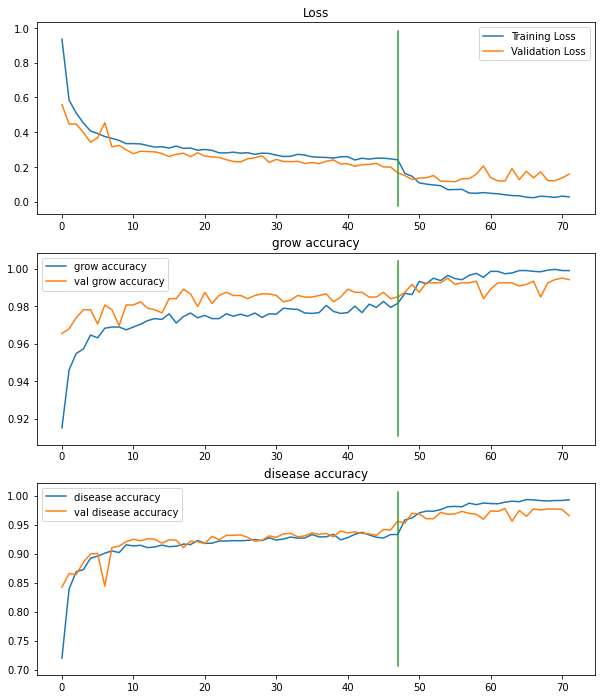

In [17]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(valid_loss, label='Validation Loss')
ax1.legend(loc='best')
plt.plot([start,start],
          plt.ylim(), label='Start Fine Tuning')
ax1.set_title('Loss')

ax2 = fig.add_subplot(3,1,2)
ax2.plot(grow_acc, label='grow accuracy')
ax2.plot(val_grow_acc, label='val grow accuracy')
ax2.legend(loc='best')
plt.plot([start,start],
          plt.ylim(), label='Start Fine Tuning')
ax2.set_title('grow accuracy')

ax3 = fig.add_subplot(3,1,3)
ax3.plot(disease_acc, label='disease accuracy')
ax3.plot(val_disease_acc, label='val disease accuracy')
ax3.legend(loc='best')
plt.plot([start,start],
          plt.ylim(), label='Start Fine Tuning')
ax3.set_title('disease accuracy')

plt.savefig('./graph1.png')
plt.show()